### Links to material:
- "Kaiming init" paper: https://arxiv.org/abs/1502.01852
- BatchNorm paper: https://arxiv.org/abs/1502.03167
- Bengio et al. 2003 MLP language model paper (pdf): https://www.jmlr.org/papers/volume3/b...
- Good paper illustrating some of the problems with batchnorm in practice: https://arxiv.org/abs/2105.07576
- ResNet implementation: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
- Linear layer (Pytorch): https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
- Batch normalization layer (Pytorch): https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#batchnorm1d - 'momentum' parameter is equal to '0.001' at multiplying 'bnmeani' or 'bnstdi'. The 'affine' parameter represents the running gain and the bias, which are learnable parameters, it is set to required_grad=True default

#### Solutions, problems:

1. **Initial loss:** During parameter generation, the biases and weights can be initialized too large, which causes the hockey stick form of the figure of the losses. If the params are too large, then it could cause large losses. This decreases efficiency since the network squashes these huge weights and biases down for iterations. Solution could be decrease these params during initialization. (Set weights to 0 is not good practice, because ...)
2. **Fixing the saturated tanh:** The activation function can get inactive, for example: tanh activation function will be 1 around x=2 and -1 around x=-2. So if there are a lot of 1, and -1 values after tanh, it means that it got saturated. On the below figures, we can see that it contains a lot of 1s and -1s, because the 'hpreact' contains a lot of huge negative and positive numbers. So for example at tanh, how we calculate its backward is: [self.grad+=(1 - t**2) * out.grad], so if 't' is 1 or -1, then the 'self.grad' will be 0, so the loss will start disappearing, because the out.grad will be 0 next time; if the t=0, then the out.grad won't be changed, just backpropagated. *A.-B. Before solving the saturation problem (hpreact: hidden layer output before activation function, h - hpreact into activation function) /  :*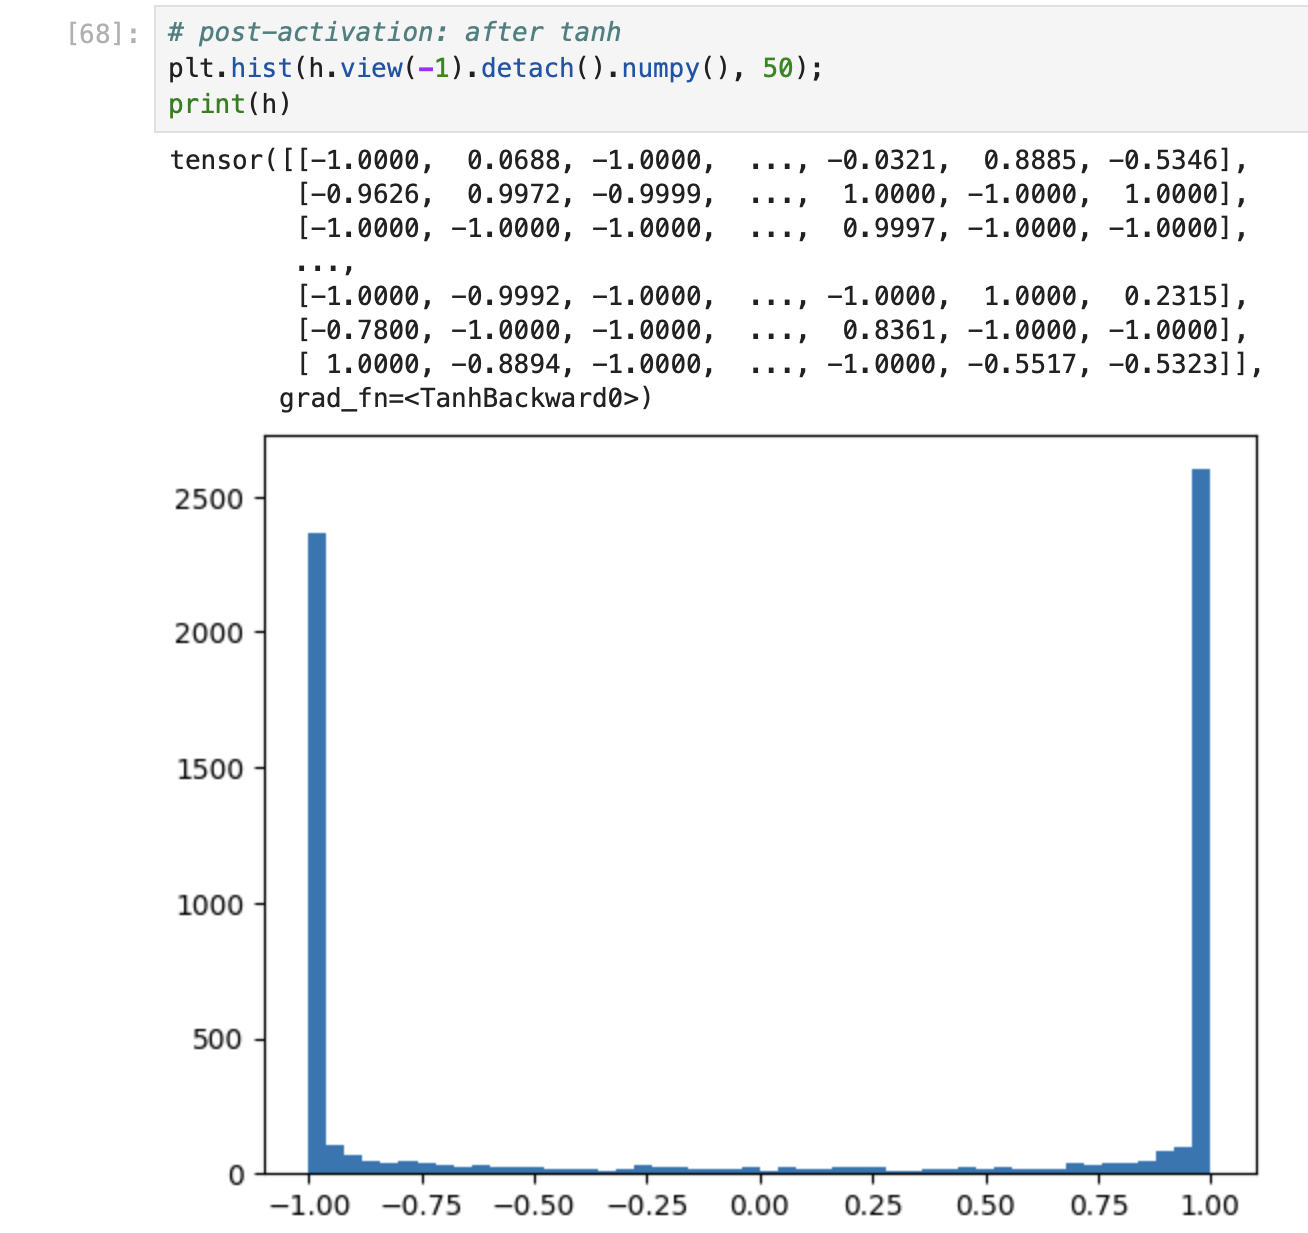 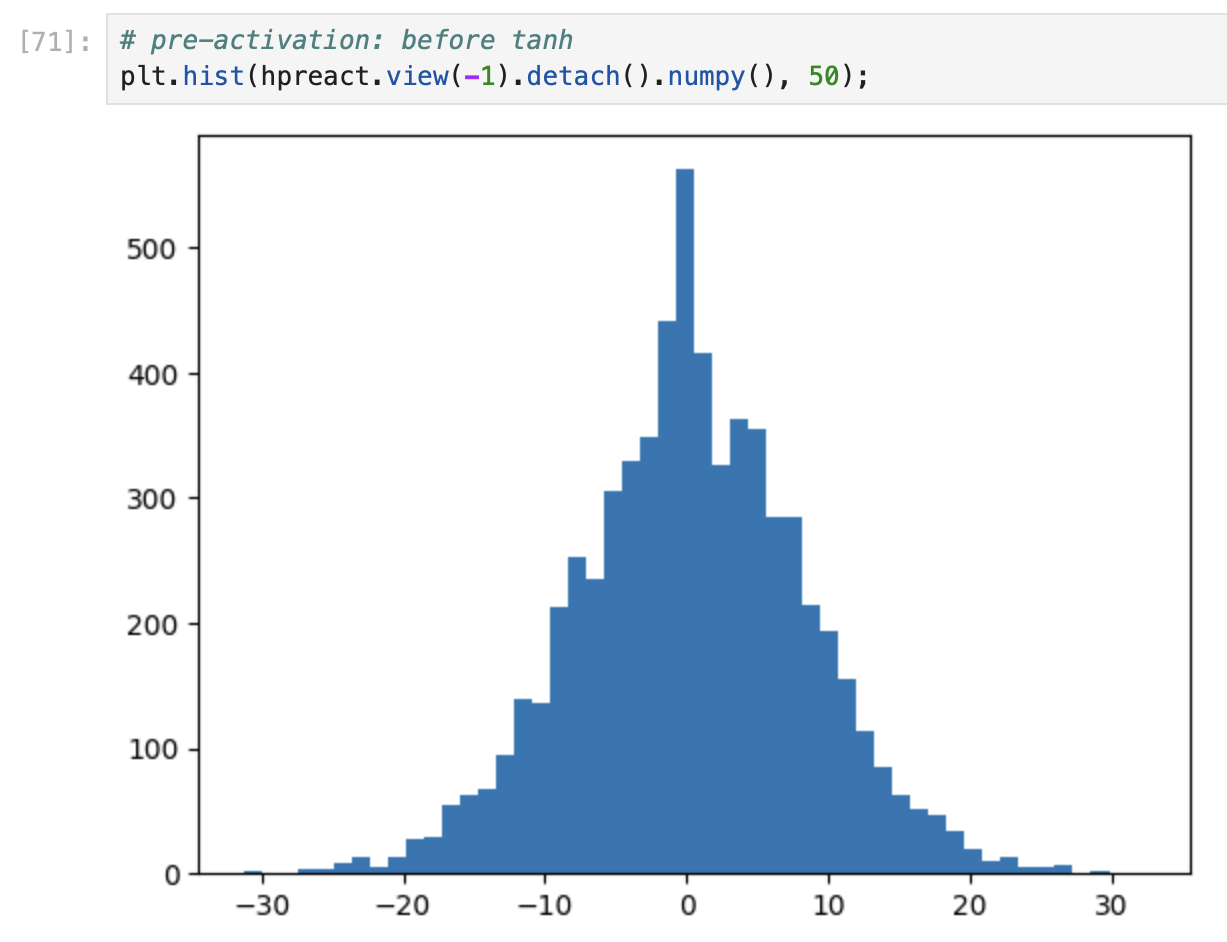 *C. The third figure shows, the 200 neurons in the hidden layer(x axis) and the 32 incoming neurons from before (y axis) and each small rectangle is white if the value of 'abs(h)' is > than 0.99 (If a whole vertical line would be full white, then that neuron would be "dead"):* 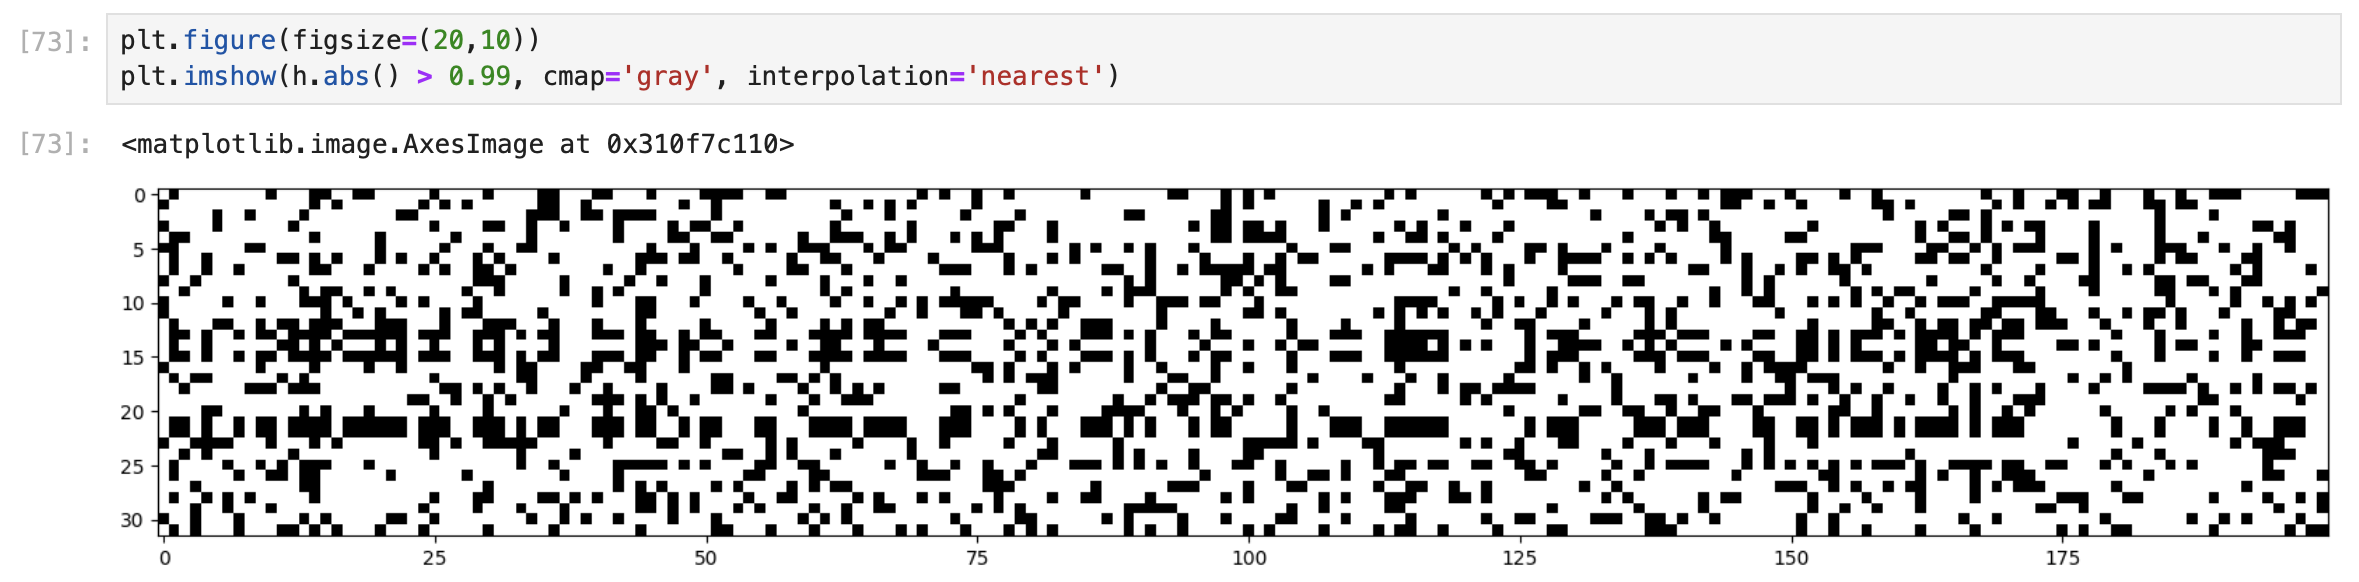 *D. Activation functions:* 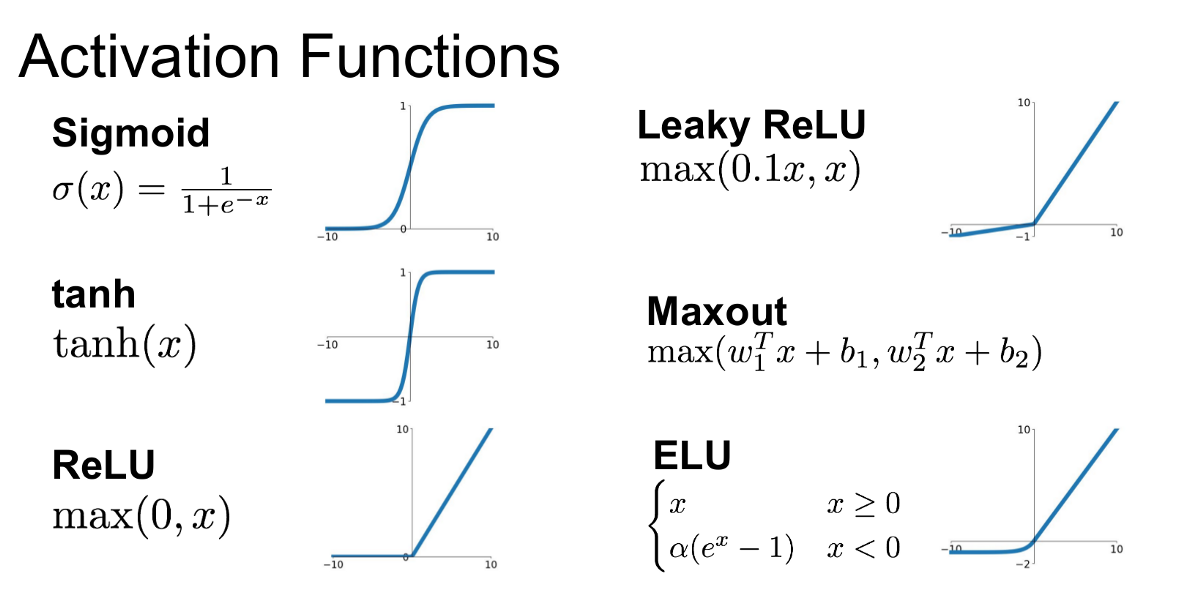 *E. The solution can be to squash the weights and biases like in the initial loss and that will create a much less saturated tanh result:* 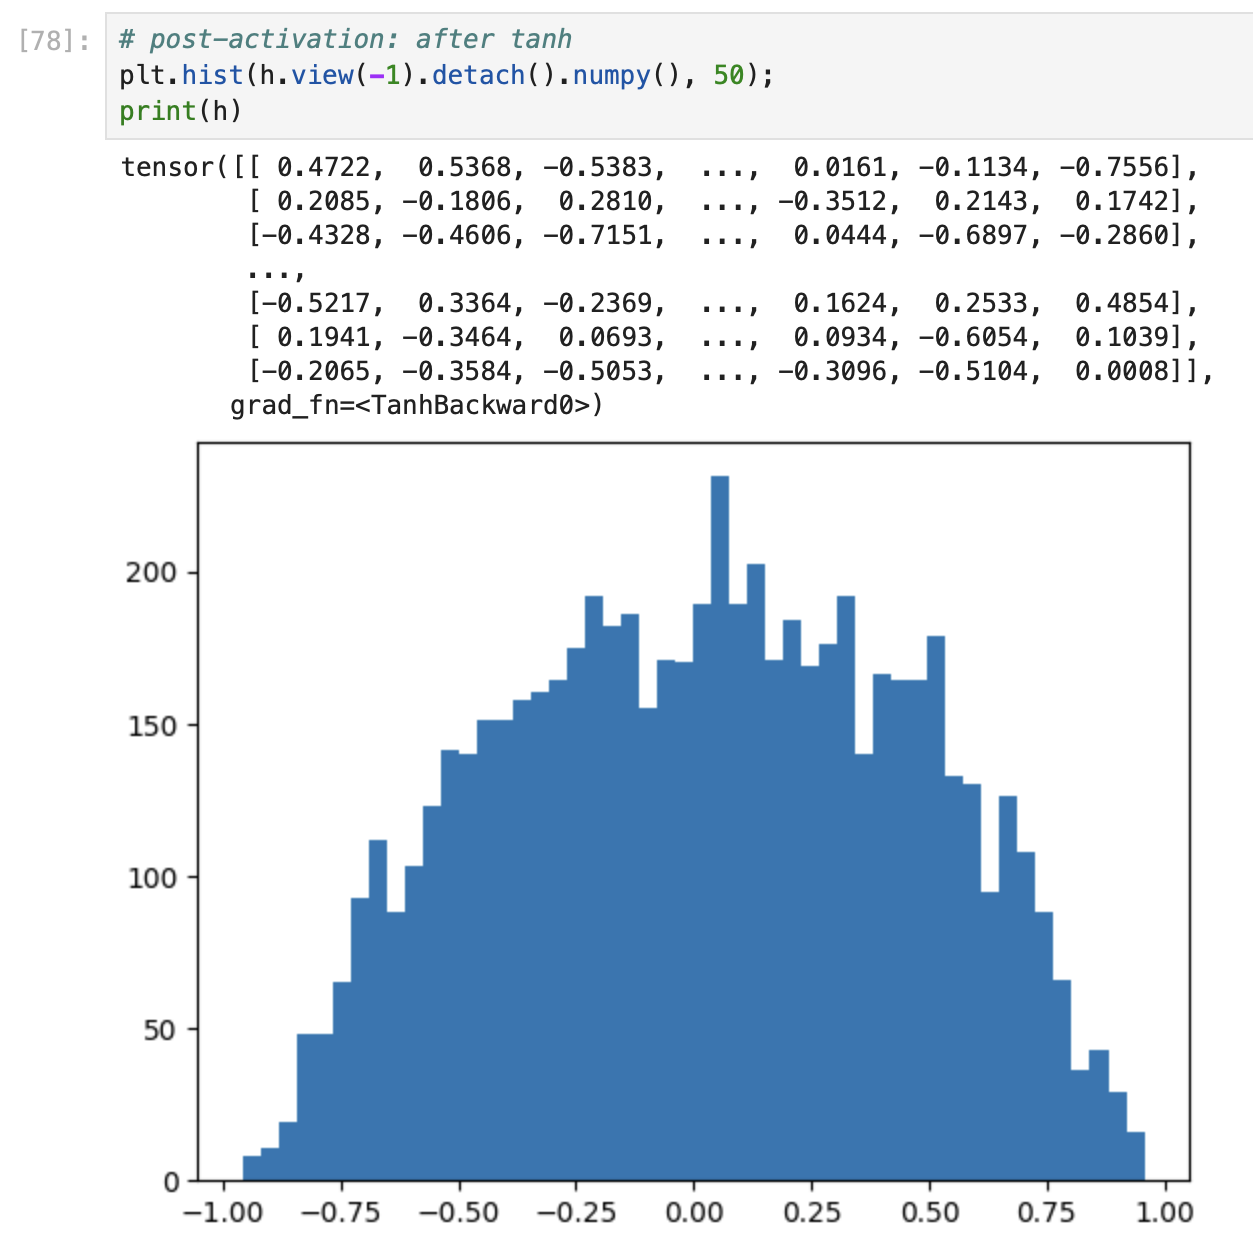 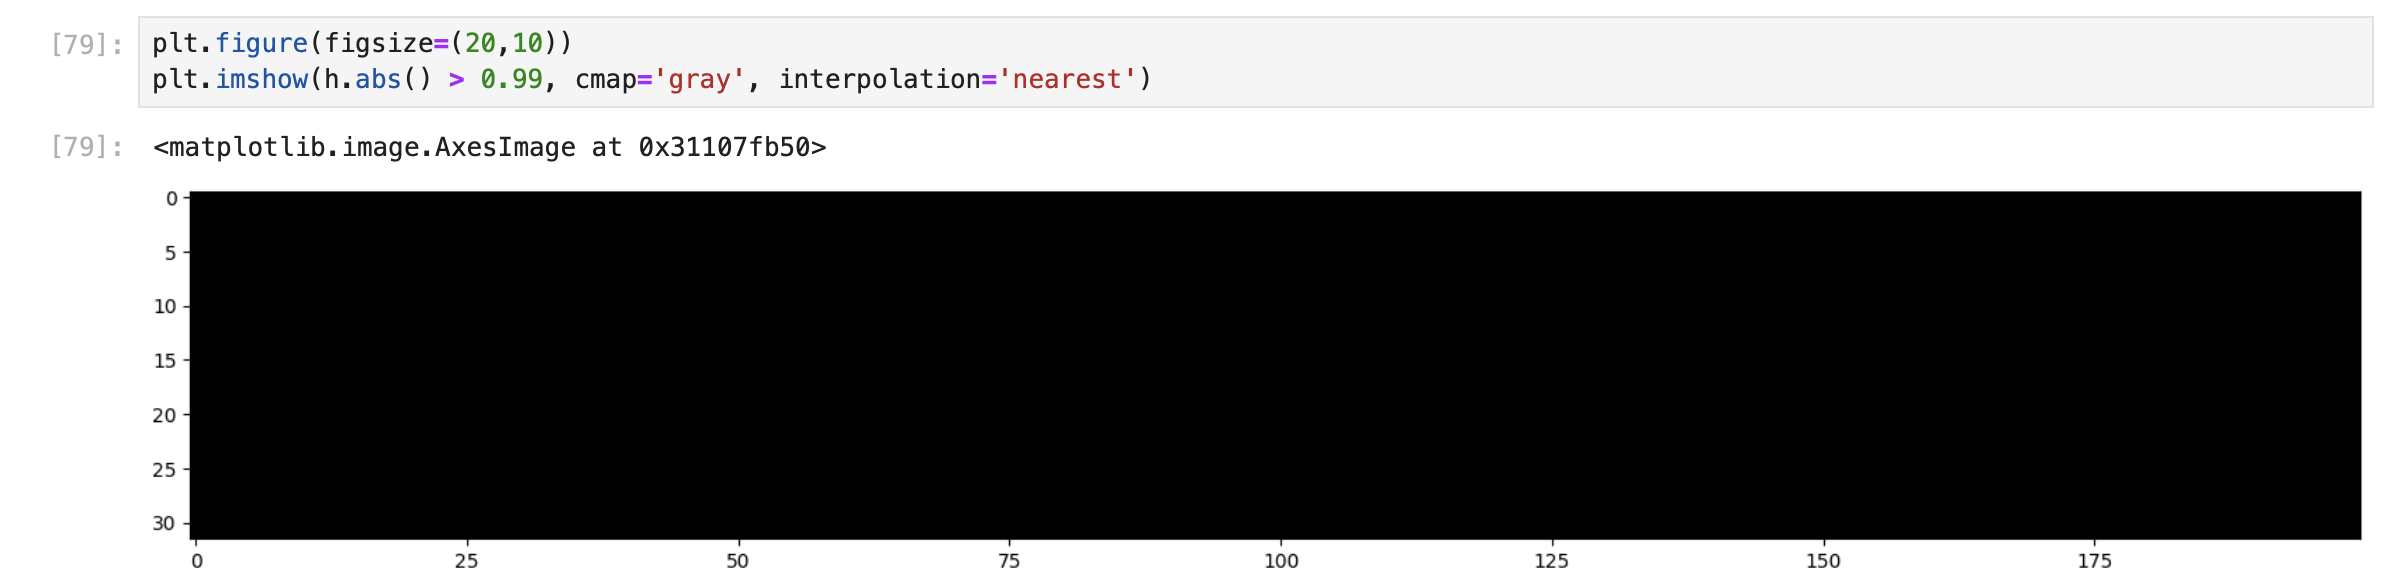

3. How to come up with the numbers to squize down the parameters to prevent saturation?
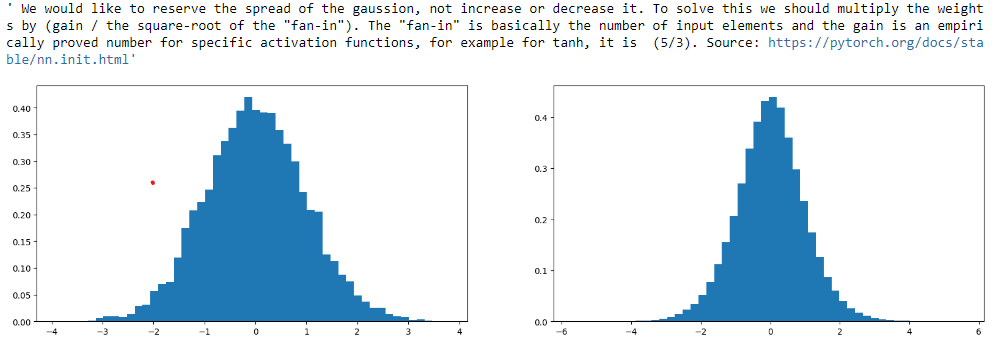

4. **Batch optimization:** Loss initialization and "fan-in"(input / in-features) tweaking are not priority nowadays, since there are better ways to optimize the net. For example batch optimization. (*https://arxiv.org/abs/1502.03167*)
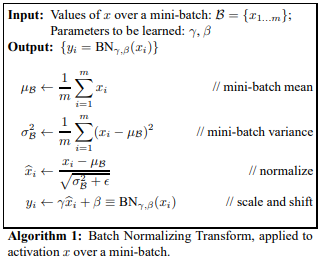
To start we know that we do not want the activation input to be too small, because then the activation won't be doing anything, or too large, because then it gets saturated. In fact we would like to be roughly gaussian. So the paper states, that there are hidden states which we would like to be roughly gaussian, then take the hidden states and normalize them to gaussian. This will do: Every single neuron now and its firing rate will be unit gaussian on the batch_size at least. (Mean / Standard deviation) 
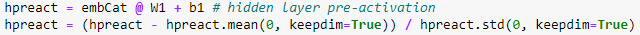
But we do not want it to be exact gaussian always, only at initialization, because we would like to be the backpropagation tell the net how should it change, to move the distribution around. That is why we have to shift and scale. At initialization, since 'bngain' is initialized to 1s and 'bnbias' is initialized to zeros, each neurons firing rate will be unit gaussian in the batch. After the 'bngain' and 'bnbias' will be trained, backpropagate as well, since they are added to the parameter list.
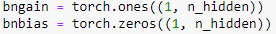


So basically at initialization, no matter what is the distribution of the incoming batch input, the outcome of 'hpreact' will be unit gaussian.

The paper also proposed that calculate the mean and the std and the end of the training process is not necessary, since it can be calculated during the training process. The BnMean/BnStd_running variables are calculated during the training, the BnMean and BnStd are calculated on the whole dataset after the training finished. As we can see the numbers are approximately are the same.

BnMean_running: **tensor([[-4.7871e+00,  1.9969e+00, -3.1459e-01,  1.4301e+00,  8.6368e-01,
          2.2400e+00,...])**

BnMean: **tensor([[-4.7923,  2.0357, -0.3720,  1.4576,  0.8949,  2.2111,...])**
         
Notes:
- When hpreact = embcat @ W1 + b1 and then hpreact = ... (hpreact - bnmeani) ..., the bias will be subtract from the hpreact via the bnmeani, so the b1 does not doing anything.

### 5. Resnet
Paper of the model:
https://arxiv.org/abs/1512.03385

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the names:
words = open("names.txt", "r").read().splitlines()
len(words)

32033

In [3]:
chars = sorted(set(''.join(words)))
stoi = { s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = { i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [4]:
block_size = 3 # context length

def build_dataset(words):
    X, Y = [], [] 
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited:
n_embd = 10 # The dimensionality of the character embedding vectors
n_hidden = 200 # The number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * (5/3 / (block_size * n_embd)**0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.02 # Notes above
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# hpreact will be roughly gaussian at the beginning, becasue of the way we initlialize, so the mean will be roughly zero and the std will be roughly one
bnmean_running = torch.zeros((1, n_hidden)) 
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [6]:
lri = []
lossi = []
stepi = []

hpreact = torch.empty((32, 200), dtype=torch.float32)
h = torch.empty((32, 200), dtype=torch.float32)

def training_ntw(epoch, batch_size, X, Y, track_lri=False, track_loss=False, track_step=False):
    # hpreact will be roughly gaussian at the beginning, becasue of the way we initlialize, so the mean will be roughly zero and the std will be roughly one
    bnmean_running = torch.zeros((1, n_hidden)) 
    bnstd_running = torch.ones((1, n_hidden))
    
    for i in range(epoch):
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g) # mini batch size is 32
        Xb, Yb = X[ix], Y[ix] # batch X,Y
        
        # Forward pass:
        emb = C[Xb] # embed the characters into vectors
        embCat = emb.view(emb.shape[0], -1) # concatenate the vectors
        hpreact = embCat @ W1# + b1 # hidden layer pre-activation, for example [input layer size, hidden layer size]. This is a Linear layer
        bnmeani = hpreact.mean(0, keepdim=True)
        bnstdi = hpreact.std(0, keepdim=True)
        hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
        with torch.no_grad():
            bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
            bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function
        print(logits.shape, Yb.shape)

        # Backward pass:
        for p in parameters:
            p.grad = None
        loss.backward()

        # Update:
        lr = 0.1 if i < 1000000 else 0.01 # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # Track stats:
        if track_lri == True: lri.append(lre[i])
        if track_loss == True: lossi.append(loss.log10().item())
        if track_step == True: stepi.append(i)
        if i % 10000 == 0:
            print(f'{i:7d}/{epoch:7d}: {loss.item():.4f}')

    # print(f'Final loss for the mini batches: {loss.item()}, BnMean_running: {bnmean_running}, BnStd_running: {bnstd_running}')
    print(f'Final loss for the mini batches: {loss.item()}')

In [7]:
training_ntw(200000, 32, Xtr, Ytr, track_loss=True)

torch.Size([32, 27]) torch.Size([32])
      0/ 200000: 3.3239
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch.Size([32])
torch.Size([32, 27]) torch

KeyboardInterrupt: 

In [ ]:
'''for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (32,), generator=g) # mini batch size is 32
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
        
    # Forward pass:
    emb = C[Xb] # embed the characters into vectors
    embCat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # print(f'emb shape: {emb.shape}, {embCat.shape}')
    hpreact = embCat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update:
    lr = 0.1 if i < 1000000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{200000:7d}: {loss.item():.4f}')
        break

print(f'Final loss for the mini batches: {loss.item()}')'''

In [ ]:
# post-activation: after tanh 
'''plt.hist(h.view(-1).detach().numpy(), 50);
print(h)'''

In [ ]:
# pre-activation: before tanh
'''plt.hist(hpreact.view(-1).detach().numpy(), 50);'''

In [ ]:
'''plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')'''

In [ ]:
plt.plot(torch.arange(200000), lossi)

In [ ]:
# Calibrate the batch norm at the end of the training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    print(bnmean)

In [ ]:
# Disable gradient calculation for eval function: https://pytorch.org/docs/stable/generated/torch.no_grad.html
# Basically for everything happens in this function it will like require_grad=False
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embCat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embCat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # Sample from the prob. distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # Shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # If we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word